In [173]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

Import movies and ratings data set and try to explore the attributes of each data set

In [174]:
movies = pd.read_csv("movies.csv")

In [175]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [176]:
ratings = pd.read_csv("ratings.csv")

In [177]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [178]:
movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


I will be doing some feature engineering in both the movies and ratings data set to get an insight into how the data looks like. 

In [223]:
movies['title'].value_counts().head()

Saturn 3 (1980)                           2
War of the Worlds (2005)                  2
Emma (1996)                               2
Eros (2004)                               2
Confessions of a Dangerous Mind (2002)    2
Name: title, dtype: int64

In [180]:
movies['movieId'].nunique()

9742

In [181]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [182]:
ratings['movieId'].nunique()

9724

In [183]:
len(ratings)

100836

In [184]:
len(movies)

9742

Define a function to get the specific genre ratings

In [185]:
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings


Filter our movies data set to that which contains movies in the genre of Romance

In [224]:
movies[movies['genres'].str.contains('Romance')].head()

,movieId,title,genres
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
6,7,Sabrina (1995),Comedy|Romance
10,11,"American President, The (1995)",Comedy|Drama|Romance
14,15,Cutthroat Island (1995),Action|Adventure|Romance


Filter the genre ratings to include the ratings of 3 genres: Animation, Comedy and Drama

In [225]:
genre_ratings = get_genre_ratings(ratings, movies, ['Animation', 'Comedy', 'Drama'], ['anime_rating', 'com_rating', 'drama_rating'])
genre_ratings.head()

,anime_rating,com_rating,drama_rating
1,4.69,4.28,4.53
2,NaN,4.00,3.88
3,0.50,1.00,0.75
4,4.00,3.51,3.48
5,4.33,3.47,3.80


Drop all null values in the genre ratings data frame

In [188]:
genre_ratings = genre_ratings.dropna()

We bias our data set to get ratings from users that either like comedy or drama or animation movies. We can also see that there is 136 people in this dataset

In [189]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['anime_rating'] < score_limit_1 - 0.2) & (genre_ratings['drama_rating'] > score_limit_2)) | ((genre_ratings['com_rating'] < score_limit_1) & (genre_ratings['anime_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset
# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)
# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  136


,index,anime_rating,com_rating,drama_rating
0,7,3.39,3.16,3.13
1,15,2.95,3.36,3.74
2,19,2.94,2.64,2.61
3,22,2.71,2.49,2.61
4,28,3.40,2.83,3.00


Use a scatterplot to sort of showcase the different mappings that exist between the ratings of different movie genres

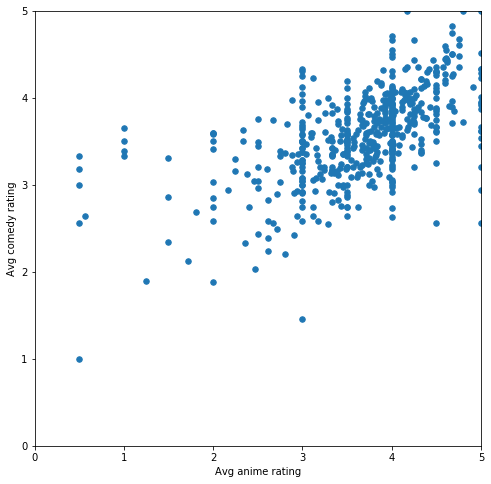

In [190]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)
# Plot the scatterplot
draw_scatterplot(genre_ratings['anime_rating'],'Avg anime rating', genre_ratings['com_rating'], 'Avg comedy rating')

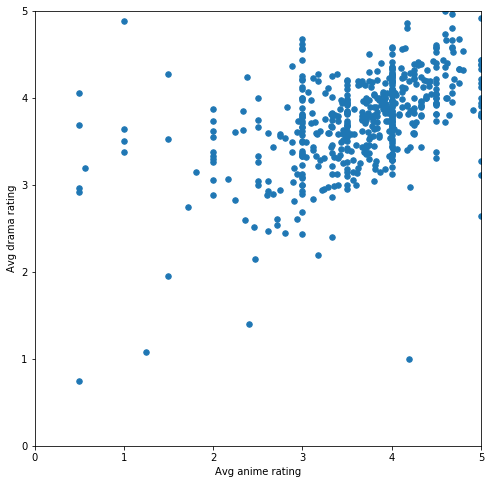

In [191]:
draw_scatterplot(genre_ratings['anime_rating'],'Avg anime rating', genre_ratings['drama_rating'], 'Avg drama rating')


We choose to go further by considering a subset of users and calculating each user's average rating for animation versus drama movies

In [192]:
X = genre_ratings[['anime_rating','drama_rating']].values

Using K means to cluster the data we can see that we can come up with three or four clusters for our data. Throuhgout these clusters we can get an understanding of the users who like drama and not anime (purple below), those who like anime and not drama (green below) and those who sort of fit in both categories (yellow).

Experimenting with four clusters below.

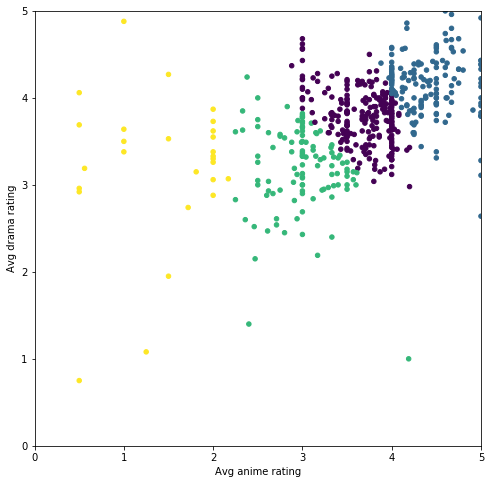

In [193]:
# Create an instance of KMeans to find four clusters
kmeans_1 = KMeans(n_clusters=4)
# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)
# Defining the cluster plotting function
def draw_clusters(genre_ratings, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg anime rating')
    ax.set_ylabel('Avg drama rating')
    

clustered = pd.concat([genre_ratings.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
draw_clusters(genre_ratings, predictions)
plt.scatter(clustered['anime_rating'], clustered['drama_rating'], c=clustered['group'], s=20, cmap='viridis')

To determine the cluster size I use the elbow method

In [194]:
wcss=[]

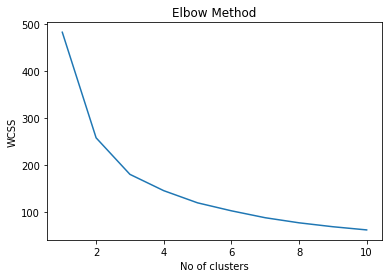

In [195]:
for i in range (1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter =300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('No of clusters')
plt.ylabel('WCSS')
plt.show()

We can see that the elbow in the arm or rather what looks like the optimum number of clusters is 3. Below we visualize our three clusters.

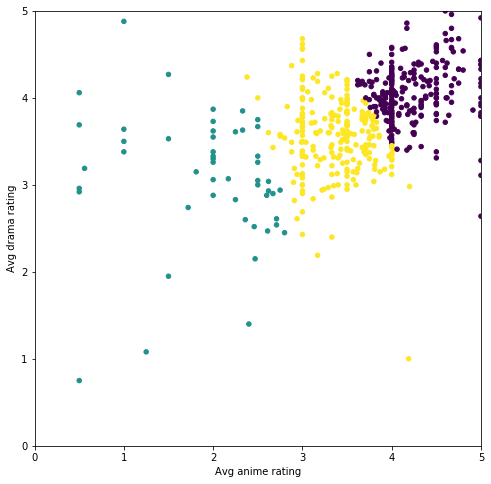

In [196]:
# Create an instance of KMeans to find three clusters
kmeans_1 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)
# Defining the cluster plotting function
def draw_clusters(genre_ratings, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg anime rating')
    ax.set_ylabel('Avg drama rating')
    

clustered = pd.concat([genre_ratings.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
draw_clusters(genre_ratings, predictions)
plt.scatter(clustered['anime_rating'], clustered['drama_rating'], c=clustered['group'], s=20, cmap='viridis')
# Plot
#draw_clusters(genre_ratings, predictions)

In [197]:
all_ratings = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )

Here, I was trying to cluster movie titles as per the rating clustering for both anime and drama movies.

In [198]:
row_dict = []
for index, row in all_ratings.iterrows():
        row_dict.append(row['movieId'])

#find the clusters        
labels = kmeans.predict(X)
clusters = {}
n = 0
for item in labels:
    if item in clusters:
        if(row_dict[n] not in clusters[item]):
            clusters[item].append(row_dict[n])
    else:
        clusters[item] = [row_dict[n]]
    n +=1

#sort the dictionary    
import collections
clusters = collections.OrderedDict(sorted(clusters.items()))

In [201]:
for item in clusters:
    print ("Cluster ", item + 1)
    n = 1
    for i in clusters[item]:
            #print (int(i),',',end="")
            movie=list(movies['title'][movies['movieId']==i])
            print(movie,',',end="")
            n += 1
            if(n > 5):
                print("\n")
                break

Cluster  1
['Toy Story (1995)'] ,['Grumpier Old Men (1995)'] ,['Heat (1995)'] ,['Seven (a.k.a. Se7en) (1995)'] ,Cluster  2
['Toy Story (1995)'] ,['Grumpier Old Men (1995)'] ,['Heat (1995)'] ,['Seven (a.k.a. Se7en) (1995)'] ,Cluster  3
['Toy Story (1995)'] ,['Grumpier Old Men (1995)'] ,['Heat (1995)'] ,['Seven (a.k.a. Se7en) (1995)'] ,Cluster  4
['Toy Story (1995)'] ,['Grumpier Old Men (1995)'] ,['Heat (1995)'] ,['Seven (a.k.a. Se7en) (1995)'] ,Cluster  5
['Toy Story (1995)'] ,['Grumpier Old Men (1995)'] ,['Heat (1995)'] ,['Seven (a.k.a. Se7en) (1995)'] ,Cluster  6
['Toy Story (1995)'] ,['Grumpier Old Men (1995)'] ,['Heat (1995)'] ,['Seven (a.k.a. Se7en) (1995)'] ,Cluster  7
['Toy Story (1995)'] ,['Grumpier Old Men (1995)'] ,['Heat (1995)'] ,['Seven (a.k.a. Se7en) (1995)'] ,Cluster  8
['Toy Story (1995)'] ,['Grumpier Old Men (1995)'] ,['Heat (1995)'] ,['Seven (a.k.a. Se7en) (1995)'] ,Cluster  9
['Toy Story (1995)'] ,['Grumpier Old Men (1995)'] ,['Heat (1995)'] ,['Seven (a.k.a. Se7en) (1

In [202]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [226]:
# Define the sorting by rating function

def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

# choose the number of movies and users and sort
n_movies = 30
n_users = 18


most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)
# Print the result
print('dataset dimensions: ', most_rated_movies_users_selection.head())


dataset dimensions:  title  Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
413                    5.0                               5.0   
589                    5.0                               4.5   
473                    3.0                               5.0   
479                    5.0                               5.0   
67                     3.5                               3.0   

title  Pulp Fiction (1994)  Silence of the Lambs, The (1991)  \
413                    5.0                               4.0   
589                    4.5                               3.5   
473                    4.0                               4.5   
479                    4.0                               4.5   
67                     2.0                               3.5   

title  Matrix, The (1999)  Star Wars: Episode IV - A New Hope (1977)  \
413                   5.0                                        5.0   
589                   4.0                                        

In the heatmap below each column is a different movie and each row is a different user. I used a heatmap below to sort of showcase a higher level clustering of the movies dataset based on the user ratings

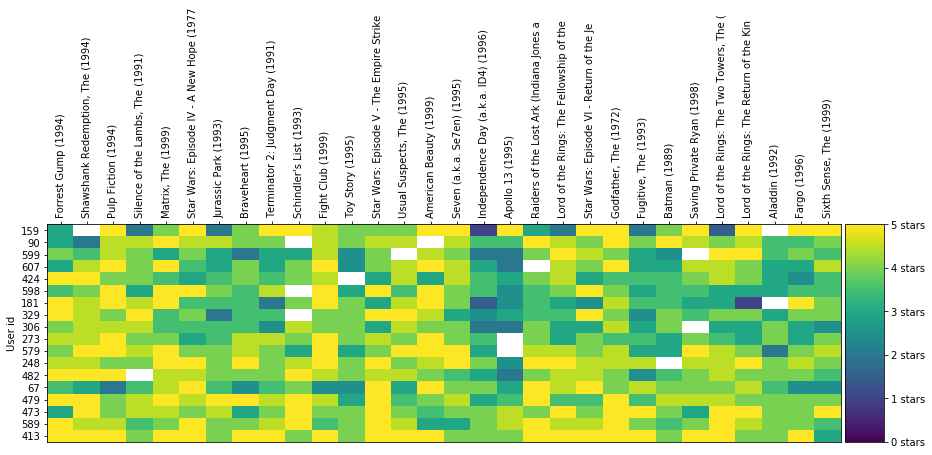

In [204]:
# Define the plotting heatmap function
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')
# Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
# Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])

plt.show()

draw_movies_heatmap(most_rated_movies_users_selection)


In [205]:
genre_ratings.mean().head(100)

anime_rating    3.639867
com_rating      3.564991
drama_rating    3.742258
dtype: float64

Here, I will go down another path to be able to find out the most rated movies by users, represnt them as a heat map in different clusters and the making a recommendation on what movies to choose based on your ratings

In [206]:
# Define Function to get the most rated movies
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies
# Pivot the dataset and choose the first 1000 movies
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000)

In [217]:
def draw_movie_clusters(clustered, max_users, max_movies):
    c=1
    for cluster_id in clustered.group.unique():
        # To improve visibility, we're showing at most max_users users and max_movies movies per cluster.
        # You can change these values to see more users & movies per cluster
        d = clustered[clustered.group == cluster_id].drop(['index', 'group'], axis=1)
        n_users_in_cluster = d.shape[0]
        
        d = sort_by_rating_density(d, max_movies, max_users)
        
        d = d.reindex(d.mean().sort_values(ascending=False).index, axis=1)
        d = d.reindex(d.count(axis=1).sort_values(ascending=False).index)
        d = d.iloc[:max_users, :max_movies]
        n_users_in_plot = d.shape[0]
        
        # We're only selecting to show clusters that have more than 9 users, otherwise, they're less interesting
        if len(d) > 9:
            print('cluster # {}'.format(cluster_id))
            print('# of users in cluster: {}.'.format(n_users_in_cluster), '# of users in plot: {}'.format(n_users_in_plot))
            fig = plt.figure(figsize=(15,4))
            ax = plt.gca()

            ax.invert_yaxis()
            ax.xaxis.tick_top()
            labels = d.columns.str[:40]

            ax.set_yticks(np.arange(d.shape[0]) , minor=False)
            ax.set_xticks(np.arange(d.shape[1]) , minor=False)

            ax.set_xticklabels(labels, minor=False)
                        
            ax.get_yaxis().set_visible(False)

            # Heatmap
            heatmap = plt.imshow(d, vmin=0, vmax=5, aspect='auto')

            ax.set_xlabel('movies')
            ax.set_ylabel('User id')

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)

            # Color bar
            cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
            cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])

            plt.setp(ax.get_xticklabels(), rotation=90, fontsize=9)
            plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', labelbottom='off', labelleft='off') 
            #print('cluster # {} \n(Showing at most {} users and {} movies)'.format(cluster_id, max_users, max_movies))

            plt.show()

In [218]:
# Conversion to sparse csr matrix
sparse_ratings = csr_matrix(pd.SparseDataFrame(most_rated_movies_1k).to_coo())

Here I'm experimenting with a number of clusters, 3 in specific to spot certain trends.

cluster # 1
# of users in cluster: 125. # of users in plot: 70


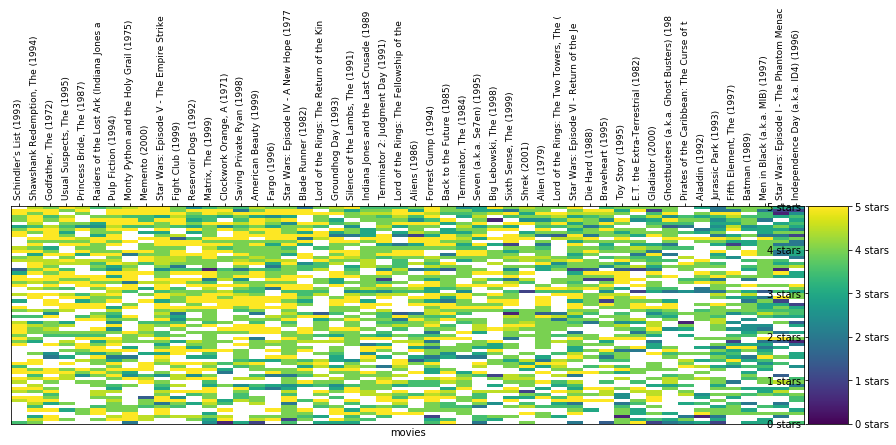

cluster # 2
# of users in cluster: 439. # of users in plot: 70


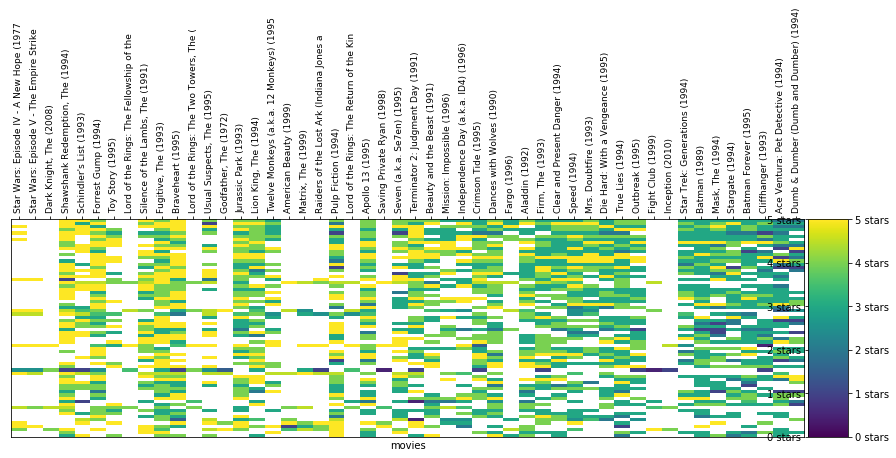

cluster # 0
# of users in cluster: 46. # of users in plot: 46


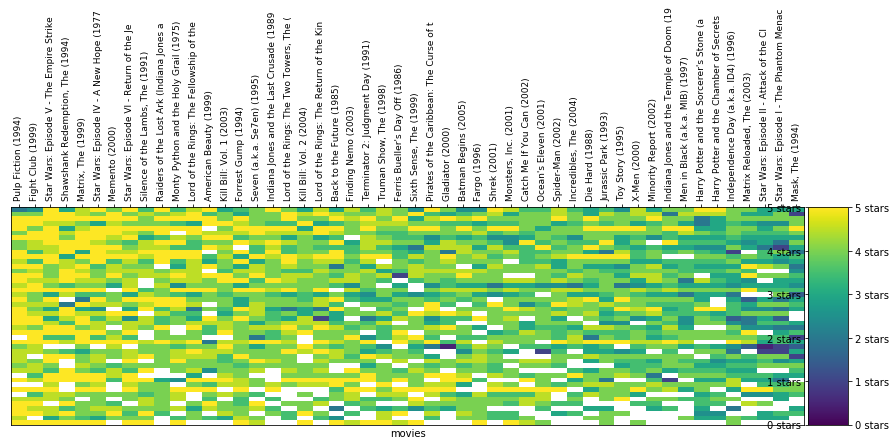

In [222]:
predictions = KMeans(n_clusters=3, algorithm='full').fit_predict(sparse_ratings)
# Select the mas number of users and movies heatmap cluster
max_users = 70
max_movies = 50
# Cluster and print some of them
clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
draw_movie_clusters(clustered, max_users, max_movies)

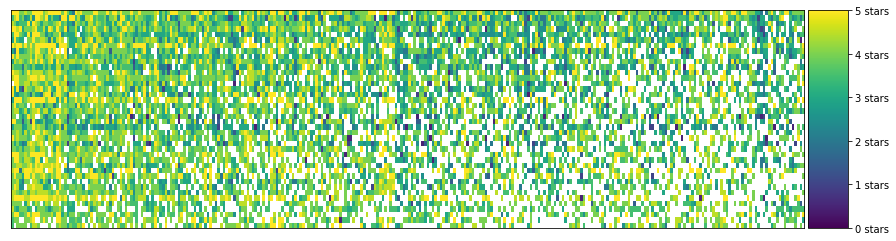

In [220]:
# Pick a cluster ID from the clusters above
cluster_number = 1
# Let's filter to only see the region of the dataset with the most number of values 
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)
# Sort and print the cluster
cluster = sort_by_rating_density(cluster, n_movies, n_users)
draw_movies_heatmap(cluster, axis_labels=False)


In [213]:
cluster.fillna('').head()

,"Matrix, The (1999)","Shawshank Redemption, The (1994)",Forrest Gump (1994),Star Wars: Episode IV - A New Hope (1977),Fight Club (1999),Pulp Fiction (1994),"Silence of the Lambs, The (1991)",American Beauty (1999),"Lord of the Rings: The Fellowship of the Ring, The (2001)","Lord of the Rings: The Two Towers, The (2002)",...,Harry Potter and the Order of the Phoenix (2007),Total Recall (1990),Austin Powers in Goldmember (2002),Big Daddy (1999),I Am Legend (2007),Whiplash (2014),Clueless (1995),Zombieland (2009),Pocahontas (1995),Hotel Rwanda (2004)
329,2.5,4,3.5,3.5,,,3,1,,,...,3,,,,3,,,,,0.5
23,2,,2,,4,5,4,4,,2,...,0.5,,,,,4,,,,
142,4.5,5,5,,4,4,4.5,3,4,4,...,,,,,,,,,,
103,,5,3,4,,3,2.5,3,5,4.5,...,,,,,,,2,,,
134,4,,4,,3.5,4,,,4,3.5,...,,,,,,,,,,


Based on the user's rating of certain movies other movies are recommended as below.

In [214]:
movie_name = "Forrest Gump (1994)"
cluster[movie_name].mean()

4.053571428571429

In [215]:
cluster.mean().head(20)

Matrix, The (1999)                                                                4.029412
Shawshank Redemption, The (1994)                                                  4.347826
Forrest Gump (1994)                                                               4.053571
Star Wars: Episode IV - A New Hope (1977)                                         4.000000
Fight Club (1999)                                                                 4.083333
Pulp Fiction (1994)                                                               4.077778
Silence of the Lambs, The (1991)                                                  4.000000
American Beauty (1999)                                                            3.794118
Lord of the Rings: The Fellowship of the Ring, The (2001)                         4.093023
Lord of the Rings: The Two Towers, The (2002)                                     4.045455
Lord of the Rings: The Return of the King, The (2003)                             4.056818

Movie recommendations are displayed as above